# Data preprocess

In [1]:
from __future__ import annotations
import html
import json
import re
from dataclasses import dataclass
from typing import List, Tuple

import pandas as pd

# -----------------------------
# Utilities
# -----------------------------
_whitespace_re = re.compile(r"\s+", re.MULTILINE)
_word_re = re.compile(r"[A-Za-z_][A-Za-z0-9_]*")
# Punctuation/delimiters typical for C/Java/JS/Solidity/Python
# We'll split code tokens by placing spaces around these, then split.
_separators = r"[\(\)\[\]\{\};:,\.\+\-\*/%&\|\^!=<>\?~]"
_sep_re = re.compile(f"({_separators})")

# String literal patterns ("...", '...', `...`)
_str_re = re.compile(r'(""".*?"""|\'\'\'.*?\'\'\'|".*?"|\'.*?\'|`.*?`)', re.DOTALL)
_num_re = re.compile(r"\b\d+(?:_\d+)*(?:\.[0-9_]+)?\b")

# Comments (C-like): // line, /* block */
_c_line_cmt = re.compile(r"//.*?(?=\n|$)")
_c_block_cmt = re.compile(r"/\*.*?\*/", re.DOTALL)
# Python: # line, triple-quoted docstrings (we'll treat as comments)
_py_line_cmt = re.compile(r"#.*?(?=\n|$)")
_py_doc_cmt = re.compile(r'(""".*?"""|\'\'\'.*?\'\'\')', re.DOTALL)

_c_like_file_ext = {".c", ".h", ".cpp", ".hpp", ".cc", ".java", ".js", ".ts", ".sol", ".cs", ".swift", ".go"}
_py_like_file_ext = {".py"}

@dataclass
class PreprocessConfig:
    lowercase: bool = True
    normalize_numbers: bool = True   # replace numbers with <NUM>
    normalize_strings: bool = True   # replace strings with <STR>
    split_identifiers: bool = True
    keep_empty: bool = False


def normalize_whitespace(text: str) -> str:
    return _whitespace_re.sub(" ", text).strip()


def split_identifiers(token: str) -> List[str]:
    """Split camelCase/mixedCase and snake_case identifiers.
    e.g. `allowedAmount_total` -> ["allowed", "Amount", "total"] -> lowercased later
    """
    # First split snake_case
    parts = re.split(r"_+", token)
    out: List[str] = []
    for p in parts:
        # Split on camelCase transitions (including digits)
        # e.g. HTTPServerError -> HTTP, Server, Error
        for m in re.finditer(r"[A-Z]?[a-z]+|[A-Z]+(?![a-z])|\d+", p):
            out.append(m.group(0))
    return [t for t in out if t]


def extract_comments_and_code(text: str, language_hint: str = "auto") -> Tuple[str, str]:
    """Return (comments_text, code_without_comments).
    Supports a broad regex-based pass for C-like and Python-like languages.
    """
    s = text
    comments: List[str] = []

    # Python-like docstrings first to avoid gobbling by string regex
    for m in _py_doc_cmt.finditer(s):
        comments.append(m.group(0))
    s = _py_doc_cmt.sub("\n", s)

    # C-like block comments
    for m in _c_block_cmt.finditer(s):
        comments.append(m.group(0))
    s = _c_block_cmt.sub("\n", s)

    # Line comments
    for m in _c_line_cmt.finditer(s):
        comments.append(m.group(0))
    s = _c_line_cmt.sub("\n", s)

    for m in _py_line_cmt.finditer(s):
        comments.append(m.group(0))
    s = _py_line_cmt.sub("\n", s)

    comments_text = "\n".join(comments)
    code_wo_comments = s
    return comments_text, code_wo_comments


def tokenize_comment_text(text: str, cfg: PreprocessConfig) -> List[str]:
    text = html.unescape(text)
    if cfg.normalize_strings:
        text = _str_re.sub(" <STR> ", text)
    if cfg.normalize_numbers:
        text = _num_re.sub(" <NUM> ", text)
    # Words only for comments; punctuation is less useful
    toks = _word_re.findall(text)
    if cfg.split_identifiers:
        expanded: List[str] = []
        for tok in toks:
            expanded.extend(split_identifiers(tok))
        toks = expanded
    if cfg.lowercase:
        toks = [t.lower() for t in toks]
    return toks if toks or cfg.keep_empty else (toks or [])


def tokenize_code(text: str, cfg: PreprocessConfig) -> List[str]:
    text = html.unescape(text)
    # Replace string and numbers with placeholders to reduce noise
    if cfg.normalize_strings:
        text = _str_re.sub(" <STR> ", text)
    if cfg.normalize_numbers:
        text = _num_re.sub(" <NUM> ", text)
    # Put spaces around separators so we can split and KEEP them
    text = _sep_re.sub(r" \1 ", text)
    # Collapse whitespace
    text = normalize_whitespace(text)
    raw_toks = text.split(" ") if text else []

    toks: List[str] = []
    for tok in raw_toks:
        if not tok:
            continue
        if tok == "<STR>" or tok == "<NUM>" or _sep_re.fullmatch(tok):
            toks.append(tok)
        else:
            if cfg.split_identifiers:
                toks.extend(split_identifiers(tok))
            else:
                toks.append(tok)
    if cfg.lowercase:
        toks = [t.lower() for t in toks]
    return toks if toks or cfg.keep_empty else (toks or [])


def preprocess_code_snippet(snippet: str, cfg: PreprocessConfig) -> Tuple[List[str], List[str]]:
    """Given raw code snippet, return (comment_tokens, code_tokens)."""
    comments_text, code_wo = extract_comments_and_code(snippet)
    cmt_toks = tokenize_comment_text(comments_text, cfg)
    code_toks = tokenize_code(code_wo, cfg)
    return cmt_toks, code_toks


def preprocess_query(q: str, cfg: PreprocessConfig) -> List[str]:
    # For queries, treat like comment text (natural language)
    return tokenize_comment_text(q, cfg)

In [30]:
codes_csv = "data/code_snippets.csv"
queries_csv = "data/test_queries.csv"
out_codes_csv = "data/code_snippets_proc.csv"
out_queries_csv = "data/test_queries_proc.csv"

cfg = PreprocessConfig(
        lowercase=True,
        split_identifiers=True,
        normalize_numbers=True,
        normalize_strings=True,
    )

df = pd.read_csv(codes_csv, engine="python")
if "code" not in df.columns:
    raise ValueError("codes CSV must contain a 'code' column")
comment_tokens_list: List[List[str]] = []
code_tokens_list: List[List[str]] = []
all_tokens_list: List[List[str]] = []

for s in df["code"].astype(str).tolist():
    cmt_toks, code_toks = preprocess_code_snippet(s, cfg)
    comment_tokens_list.append(cmt_toks)
    code_tokens_list.append(code_toks)
    all_tokens_list.append(cmt_toks + code_toks)

# df["comment_tokens"] = [json.dumps(x, ensure_ascii=False) for x in comment_tokens_list]
df["code_tokens"] = [json.dumps(x, ensure_ascii=False) for x in code_tokens_list]
# df["all_tokens"] = [json.dumps(x, ensure_ascii=False) for x in all_tokens_list]
df.to_csv(out_codes_csv, index=False)

# Process queries
df = pd.read_csv(queries_csv, engine="python")
if "query" not in df.columns:
    raise ValueError("queries CSV must contain a 'query' column")
query_tokens_list: List[List[str]] = []
for s in df["query"].astype(str).tolist():
    q_toks = preprocess_query(s, cfg)
    query_tokens_list.append(q_toks)
df["query_tokens"] = [json.dumps(x, ensure_ascii=False) for x in query_tokens_list]
df.to_csv(out_queries_csv, index=False)

code_snippets = pd.read_csv(out_codes_csv, engine="python")['code_tokens']
queries = pd.read_csv(out_queries_csv, engine="python")['query_tokens']

In [33]:
def output_submission_file(results, output_file):
    with open(output_file, 'w') as f:
        f.write("query_id,code_id\n")
        for query_id, code_ids in enumerate(results):
            code_ids_str = ' '.join(map(str, code_ids))
            f.write(f"{query_id+1},{code_ids_str}\n")

# Sparse Retrieval

## TF-IDF

In [71]:
import math
import numpy as np
import json
from collections import defaultdict

class TFIDF:
    '''
    documents: List of documents (strings)
    term_freqs: List of term frequency dictionaries for each document ex: [{'term1': 2, 'term2': 1}, ...]
    doc_freqs: Document frequency dictionary for terms ex: {'term1': 3, 'term2': 5}
    num_docs: Total number of documents
    vocabulary: Set of unique terms across all documents
    idf: Inverse Document Frequency dictionary for terms
    tfidf_matrix: 2D numpy array storing TF-IDF scores for documents
    vocab_to_idx: Mapping from term to its index in the vocabulary
    '''
    def __init__(self):
        self.documents = []
        self.term_freqs = []
        self.doc_freqs = defaultdict(int)
        self.num_docs = 0
        self.vocabulary = set()
        self.idf = defaultdict(float)
        self.tfidf_matrix = None
        self.vocab_to_idx = defaultdict(int)

    def add_document(self, document_tokens):
        if isinstance(document_tokens, str):
            try:
                tokens = json.loads(document_tokens)
            except json.JSONDecodeError:
                
                tokens = document_tokens.split()
        else:
            tokens = document_tokens
        self.documents.append(tokens)
        self.num_docs += 1
        term_count = defaultdict(int)

        for term in tokens:
            term_count[term] += 1
            self.vocabulary.add(term)

        self.term_freqs.append(term_count)

        for term in term_count.keys():
            self.doc_freqs[term] += 1
    
    def _build_vocab_index(self):
        self.vocabulary = list(self.vocabulary)
        self.vocab_to_idx = {term: idx for idx, term in enumerate(self.vocabulary)}
        
    def compute_tfidf(self):
        if self.tfidf_matrix is not None:
            return self.tfidf_matrix
            
        self._build_vocab_index()
        vocab_size = len(self.vocabulary)
        
        for term in self.vocabulary:
            self.idf[term] = math.log((1 + (self.num_docs/self.doc_freqs[term])), 2)
        
        self.tfidf_matrix = np.zeros((self.num_docs, vocab_size))
        
        for doc_idx, term_count in enumerate(self.term_freqs):
            for term, count in term_count.items():
                if term in self.vocab_to_idx:
                    tf = 1 + math.log(count, 2)
                    tfidf_val = tf * self.idf[term]
                    self.tfidf_matrix[doc_idx][self.vocab_to_idx[term]] = tfidf_val
        
        return self.tfidf_matrix

    def get_query_vector(self, query_tokens):
        
        if self.tfidf_matrix is None:
            self.compute_tfidf()
        
        if isinstance(query_tokens, str):
            try:
                tokens = json.loads(query_tokens)
            except json.JSONDecodeError:
                tokens = query_tokens.split()
        else:
            tokens = query_tokens
        
        query_term_count = defaultdict(int)
        for term in tokens:
            query_term_count[term] += 1

        query_vector = np.zeros(len(self.vocabulary))
        
        for term, count in query_term_count.items():
            if term in self.vocab_to_idx:
                tf = 1 + math.log(count, 2)
                idf = self.idf.get(term, 0.0)
                query_vector[self.vocab_to_idx[term]] = tf * idf
                
        return query_vector
    
    def compute_similarity_batch(self, query_vector):
        
        dot_products = np.dot(self.tfidf_matrix, query_vector)
        
        # Document Length Normalization
        doc_norms = np.linalg.norm(self.tfidf_matrix, axis=1)
        query_norm = np.linalg.norm(query_vector)
        
        valid_mask = (doc_norms > 0) & (query_norm > 0)
        similarities = np.zeros(len(doc_norms))
        similarities[valid_mask] = dot_products[valid_mask] / (doc_norms[valid_mask] * query_norm)
        
        return similarities
    
    def get_top_k_similar_documents(self, query_tokens, k):
        
        query_vector = self.get_query_vector(query_tokens)
        similarities = self.compute_similarity_batch(query_vector)
        
        if k >= len(similarities):
            top_k_indices = np.argsort(similarities)[::-1]
        else:
            top_k_indices = np.argpartition(similarities, -k)[-k:]
            top_k_indices = top_k_indices[np.argsort(similarities[top_k_indices])[::-1]]
        
        # need to plus 1 to indices for 1-based indexing
        top_k_indices += 1
        return top_k_indices.tolist()

In [72]:
tfidf = TFIDF()

for code in code_snippets:
    tfidf.add_document(code)
    
tfidf.compute_tfidf()

top_k_results = []
for query in queries:
    top_k = tfidf.get_top_k_similar_documents(query, 10)
    top_k_results.append(top_k)

output_submission_file(top_k_results, 'results/tf_idf_submission.csv')

## BM25

In [ ]:
# BM25 implementation
import math
import json
from collections import defaultdict
import numpy as np

class BM25:
    def __init__(self, k1=1.5, b=0.75):
        self.documents = []
        self.term_freqs = []
        self.doc_freqs = defaultdict(int)
        self.num_docs = 0
        self.vocabulary = set()
        self.doc_lengths = []
        self.avg_doc_len = 0
        self.k1 = k1
        self.b = b
        self._precomputed_idf = {}
        self._precomputed_norms = None

    def add_document(self, document_tokens):
        if isinstance(document_tokens, str):
            try:
                terms = json.loads(document_tokens)
            except json.JSONDecodeError:
                terms = document_tokens.split()
        else:
            terms = document_tokens
            
        self.documents.append(terms)
        self.doc_lengths.append(len(terms))
        self.num_docs += 1
        term_count = defaultdict(int)

        for term in terms:
            term_count[term] += 1
            self.vocabulary.add(term)

        self.term_freqs.append(term_count)

        for term in term_count.keys():
            self.doc_freqs[term] += 1
    
    def _precompute_idf(self):
        self.avg_doc_len = sum(self.doc_lengths) / self.num_docs
        for term in self.vocabulary:
            df = self.doc_freqs[term]
            self._precomputed_idf[term] = math.log((self.num_docs - df + 0.5) / (df + 0.5))
    
    def _precompute_normalization_factors(self):
        self._precomputed_norms = np.array([
            self.k1 * (1 - self.b + self.b * (doc_len / self.avg_doc_len))
            for doc_len in self.doc_lengths
        ])
    
    def compute_similarity_batch(self, query_tokens):
        if not self._precomputed_idf:
            self._precompute_idf()
        if self._precomputed_norms is None:
            self._precompute_normalization_factors()
            
        if isinstance(query_tokens, str):
            try:
                query_terms = json.loads(query_tokens)
            except json.JSONDecodeError:
                query_terms = query_tokens.split()
        else:
            query_terms = query_tokens
            
        similarities = np.zeros(self.num_docs)
        
        for doc_idx in range(self.num_docs):
            score = 0.0
            term_freq_doc = self.term_freqs[doc_idx]
            norm_factor = self._precomputed_norms[doc_idx]
            
            for term in query_terms:
                if term in self.vocabulary:
                    tf = term_freq_doc.get(term, 0)
                    if tf > 0:  # 只計算有出現的詞彙
                        idf = self._precomputed_idf[term]
                        normalized_tf = (tf * (self.k1 + 1)) / (tf + norm_factor)
                        score += idf * normalized_tf
            
            similarities[doc_idx] = score

        return similarities

    def get_top_k_similar_documents(self, query_tokens, k):
        similarities = self.compute_similarity_batch(query_tokens)

        if k >= len(similarities):
            top_k_indices = np.argsort(similarities)[::-1]      
        else:
            top_k_indices = np.argpartition(similarities, -k)[-k:]
            top_k_indices = top_k_indices[np.argsort(similarities[top_k_indices])[::-1]]
        
        # need to plus 1 to indices for 1-based indexing
        top_k_indices += 1
        return top_k_indices.tolist()

In [70]:
bm25 = BM25()

for code in code_snippets:
    bm25.add_document(code)

top_k_results = []
for query in queries:
    top_k = bm25.get_top_k_similar_documents(query, 10)
    top_k_results.append(top_k)

output_submission_file(top_k_results, 'results/bm25_submission.csv')

# Dense Retrieval

## Pre-trained model

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from tqdm import tqdm
import ast
import numpy as np

model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

def tokens_to_ids_batch(batch_tokens, max_len, pad_token_id):
    input_ids = []
    attention_masks = []

    for tokens in batch_tokens:
        ids = tokenizer.convert_tokens_to_ids(tokens)

        # ids = [tokenizer.cls_token_id] + ids + [tokenizer.sep_token_id]

        ids = ids[:max_len]
        attn_mask = [1] * len(ids)
        while len(ids) < max_len:
            ids.append(pad_token_id)
            attn_mask.append(0)

        input_ids.append(ids)
        attention_masks.append(attn_mask)

    return {
        "input_ids": torch.tensor(input_ids),
        "attention_mask": torch.tensor(attention_masks)
    }

def encode_tokens_list(tokens_list, max_len=256, batch_size=32):
    embeddings = []
    pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id 
    for i in tqdm(range(0, len(tokens_list), batch_size)):
        batch_tokens = tokens_list[i:i+batch_size]
        encoded_input = tokens_to_ids_batch(batch_tokens, max_len, pad_token_id)
        with torch.no_grad():
            model_output = model(**encoded_input)
        batch_embeddings = model_output.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings) 

code_snippets = pd.read_csv(out_codes_csv, engine="python")['code_tokens'].apply(ast.literal_eval).tolist()
queries = pd.read_csv(out_queries_csv, engine="python")['query_tokens'].apply(ast.literal_eval).tolist()

code_embeds = encode_tokens_list(code_snippets, max_len=256)
query_embeds = encode_tokens_list(queries, max_len=128)

code_embeds = normalize(code_embeds)
query_embeds = normalize(query_embeds)

similarity_matrix = cosine_similarity(query_embeds, code_embeds)

top_k = 10
results = []
for i in range(len(queries)):
    top_indices = similarity_matrix[i].argsort()[-top_k:][::-1]
    top_indices += 1  # Convert to 1-based indexing
    results.append(top_indices.tolist())

output_submission_file(results, 'results/pre_trained_submission.csv')

100%|██████████| 16/16 [00:17<00:00,  1.11s/it]


## Fine-tuned model

In [2]:
# Fine-tune a pre-trained model on a data/train_queries.csv which contains code snippets and their corresponding queries.
# data only contain code and query

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.optim import AdamW
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_name = "microsoft/codebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
base_model = AutoModel.from_pretrained(model_name)

class CodeQuerySimilarityModel(nn.Module):
    def __init__(self, base_model, hidden_size=768):
        super().__init__()
        self.encoder = base_model
        self.similarity_head = nn.Sequential(
            nn.Linear(hidden_size * 2, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
        
    def forward(self, code_input_ids, code_attention_mask, query_input_ids, query_attention_mask):
        code_outputs = self.encoder(input_ids=code_input_ids, attention_mask=code_attention_mask)
        code_embed = code_outputs.last_hidden_state[:, 0, :]
    
        query_outputs = self.encoder(input_ids=query_input_ids, attention_mask=query_attention_mask)
        query_embed = query_outputs.last_hidden_state[:, 0, :]
        
        combined = torch.cat([code_embed, query_embed], dim=-1)
        similarity = self.similarity_head(combined)
        
        return similarity.squeeze(), code_embed, query_embed

/Users/coconut/114-1/IR/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


### Training data

In [6]:
class CodeQueryDataset(Dataset):
    def __init__(self, codes, queries, labels, tokenizer, max_code_len=512, max_query_len=128):
        self.codes = codes
        self.queries = queries
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_code_len = max_code_len
        self.max_query_len = max_query_len
        
    def __len__(self):
        return len(self.codes)
    
    def __getitem__(self, idx):
        code = str(self.codes[idx])
        query = str(self.queries[idx])
        label = self.labels[idx]
        
        code_encoding = self.tokenizer(
            code,
            truncation=True,
            padding='max_length',
            max_length=self.max_code_len,
            return_tensors='pt'
        )
        
        query_encoding = self.tokenizer(
            query,
            truncation=True,
            padding='max_length',
            max_length=self.max_query_len,
            return_tensors='pt'
        )
        
        return {
            'code_input_ids': code_encoding['input_ids'].squeeze(),
            'code_attention_mask': code_encoding['attention_mask'].squeeze(),
            'query_input_ids': query_encoding['input_ids'].squeeze(),
            'query_attention_mask': query_encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float)
        }

train_df = pd.read_csv('data/train_queries.csv')
print(f"Training data shape: {train_df.shape}")

train_df['code'] = train_df['code'].apply(clean_text)
train_df['query'] = train_df['query'].apply(clean_text)

positive_codes = train_df['code'].tolist()
positive_queries = train_df['query'].tolist()
positive_labels = [1.0] * len(positive_codes)

negative_codes = []
negative_queries = []
negative_labels = []

n_negatives = len(positive_codes)

for i in tqdm(range(n_negatives)):
    # 隨機選擇不同的 query
    neg_idx = random.randint(0, len(positive_queries) - 1)
    while neg_idx == i:  # 確保不是同一對
        neg_idx = random.randint(0, len(positive_queries) - 1)
    
    negative_codes.append(positive_codes[i])
    negative_queries.append(positive_queries[neg_idx])
    negative_labels.append(0.0)

all_codes = positive_codes + negative_codes
all_queries = positive_queries + negative_queries
all_labels = positive_labels + negative_labels

indices = list(range(len(all_codes)))
random.shuffle(indices)

all_codes = [all_codes[i] for i in indices]
all_queries = [all_queries[i] for i in indices]
all_labels = [all_labels[i] for i in indices]

print(f"Total training samples: {len(all_codes)} (positive: {len(positive_codes)}, negative: {len(negative_codes)})")

split_idx = int(0.8 * len(all_codes))
train_codes = all_codes[:split_idx]
train_queries = all_queries[:split_idx]
train_labels = all_labels[:split_idx]

val_codes = all_codes[split_idx:]
val_queries = all_queries[split_idx:]
val_labels = all_labels[split_idx:]

print(f"Train samples: {len(train_codes)}, Validation samples: {len(val_codes)}")

train_dataset = CodeQueryDataset(train_codes, train_queries, train_labels, tokenizer)
val_dataset = CodeQueryDataset(val_codes, val_queries, val_labels, tokenizer)

Training data shape: (500, 2)


100%|██████████| 500/500 [00:00<00:00, 1547713.65it/s]

Total training samples: 1000 (positive: 500, negative: 500)
Train samples: 800, Validation samples: 200


In [7]:
# 訓練循環
def train_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    progress_bar = tqdm(train_loader, desc="Training")
    
    for batch in progress_bar:
        code_input_ids = batch['code_input_ids'].to(device)
        code_attention_mask = batch['code_attention_mask'].to(device)
        query_input_ids = batch['query_input_ids'].to(device)
        query_attention_mask = batch['query_attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        predictions, code_embeds, query_embeds = model(
            code_input_ids, code_attention_mask,
            query_input_ids, query_attention_mask
        )
        
        loss = criterion(predictions, labels)
        
        # 反向傳播
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        # 統計
        total_loss += loss.item()
        predicted_labels = (predictions > 0.5).float()
        correct_predictions += (predicted_labels == labels).sum().item()
        total_predictions += labels.size(0)
        
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{correct_predictions/total_predictions:.4f}'
        })
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            code_input_ids = batch['code_input_ids'].to(device)
            code_attention_mask = batch['code_attention_mask'].to(device)
            query_input_ids = batch['query_input_ids'].to(device)
            query_attention_mask = batch['query_attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            predictions, _, _ = model(
                code_input_ids, code_attention_mask,
                query_input_ids, query_attention_mask
            )
            
            loss = criterion(predictions, labels)
            
            total_loss += loss.item()
            predicted_labels = (predictions > 0.5).float()
            correct_predictions += (predicted_labels == labels).sum().item()
            total_predictions += labels.size(0)
    
    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_predictions
    
    return avg_loss, accuracy

## Training

In [9]:
batch_size = 8  # 根據GPU記憶體調整
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = CodeQuerySimilarityModel(base_model)
model.to(device)

optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
num_epochs = 3
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

criterion = nn.BCELoss()

best_val_loss = float('inf')
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    print("-" * 50)
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved best model!")

print("Fine-tuning completed!")


Epoch 1/3
--------------------------------------------------


Training:  92%|█████████▏| 92/100 [10:42<00:55,  6.99s/it, loss=0.6153, acc=0.4742]


KeyboardInterrupt: 

Loading best model for inference...
Encoding code snippets with fine-tuned model...
Encoding code snippets with fine-tuned model...


Encoding: 100%|██████████| 63/63 [00:35<00:00,  1.80it/s]


Encoding queries with fine-tuned model...


Encoding: 100%|██████████| 32/32 [00:11<00:00,  2.69it/s]



Code embeddings shape: (500, 768)
Query embeddings shape: (500, 768)
Computing similarity matrix...
Fine-tuned model results saved to fine_tuned_submission.csv


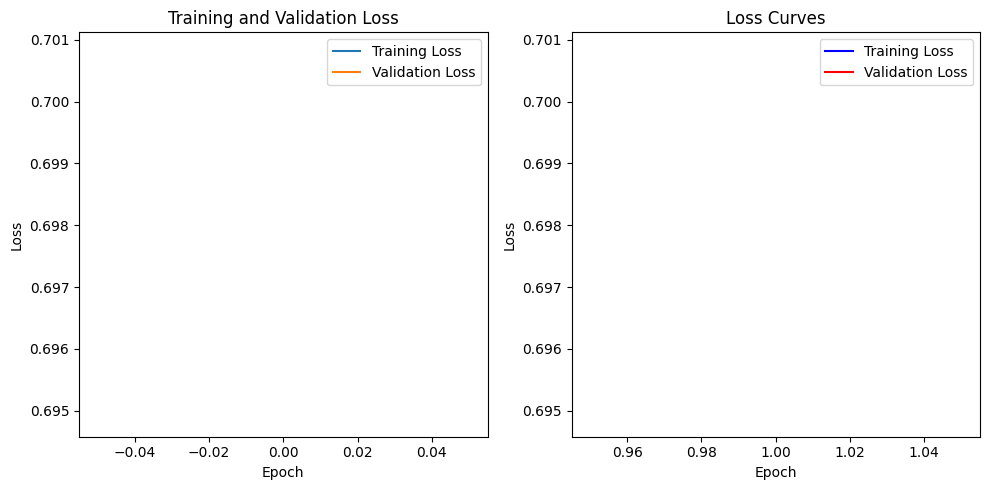

Final training loss: 0.7008
Final validation loss: 0.6949


In [ ]:
print("Loading best model for inference...")

inference_model = CodeQuerySimilarityModel(base_model)
inference_model.to(device)
inference_model.load_state_dict(torch.load('best_model.pth'))
inference_model.eval()

def encode_texts_finetuned(texts, max_len=512, batch_size=16):
    embeddings = []
    inference_model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
            batch_texts = texts[i:i+batch_size]
            
            inputs = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_len,
                return_tensors='pt'
            )
            
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            outputs = inference_model.encoder(**inputs)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)


code_embeddings_ft = encode_texts_finetuned(codes, max_len=512, batch_size=8)

query_embeddings_ft = encode_texts_finetuned(queries, max_len=128, batch_size=16)

print(f"Code embeddings shape: {code_embeddings_ft.shape}")
print(f"Query embeddings shape: {query_embeddings_ft.shape}")

from sklearn.preprocessing import normalize
code_embeddings_ft_norm = normalize(code_embeddings_ft, norm='l2')
query_embeddings_ft_norm = normalize(query_embeddings_ft, norm='l2')

print("Computing similarity matrix...")
similarity_matrix_ft = np.dot(query_embeddings_ft_norm, code_embeddings_ft_norm.T)

top_k = 10
results_ft = []

for i in range(len(queries)):
    if top_k >= len(codes):
        top_indices = np.argsort(similarity_matrix_ft[i])[::-1]
    else:
        top_indices = np.argpartition(similarity_matrix_ft[i], -top_k)[-top_k:]
        top_indices = top_indices[np.argsort(similarity_matrix_ft[i][top_indices])[::-1]]
    
    results_ft.append(top_indices.tolist())

output_submission_file(results_ft, 'fine_tuned_submission.csv')
print("Fine-tuned model results saved to fine_tuned_submission.csv")


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r-', label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")